# Labs 7 - 10: A CA model of Natural Disturbance
In [1990](https://doi.org/10.1016/0375-9601(90)90451-S) Bak, Chen and Tang proposed a cellular automaton that is an abstract model of a forest fire. Each cell is in one of three states: empty, occupied by forest, or on fire.

3 ecological processes are modelled: forest regeneration, fire ignition, and fire spread

  * empty cells "regenerate" forest at a fixed rate, $p$
  * forest fires ignite with a regular but small frequency, $f$
  * forested cells catch fire when their neighbours are burning, and burn out in one time step.

Over the remainder of term, we will develop 2D CA class that implements this model and run computational experiments on the spatial and temporal patterns that emerge.

In [449]:
%matplotlib inline

import time
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

### Helpers
Some useful, re-usable bits of code developed in previous notebooks...

In [450]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)


def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [451]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

# Lab 7:  Implementing the Bak, Chen, Tang Model

In this lab we will implement a 2D CA model using the same techniques as the GoL, Diffusion, and Percolation models.
We are setting up the model we will use in future labs to run some computational experiments to answer questions about this system.

## Ex. 7.1: Define the Cellular Automata
This 2D CA will be similar to those we've seen before.

1. Define the kernel (correlation matrix) to compute the spread of fire
    * what do we need to know about a cell's neighbourhood to know if it should catch fire?
    * how can we encode that using a dot product with a 3 x 3 correlation matrix?

2. The step function will be more complex because it must implement the **4 rules**:

  *  An empty cell becomes occupied with probability $p$.
  *  An occupied cell spontaneously burns, with probability $f$, even if none of its neighbors is on fire.
  *  An occupied cell that is on fire becomes an empty cell in the next time step.
  *  A occupied catches fire if any of its neighbors is on fire.

Typical values for the parameters are $p=0.01$ and $f=0.001$

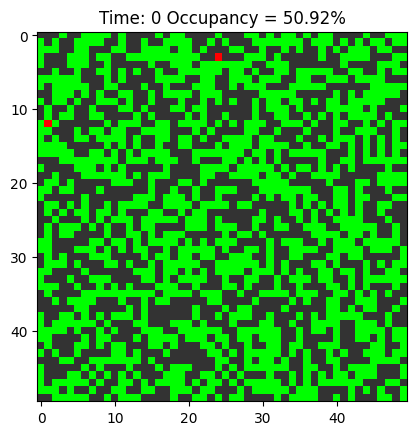

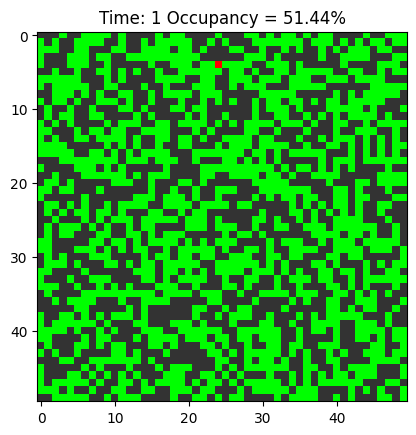

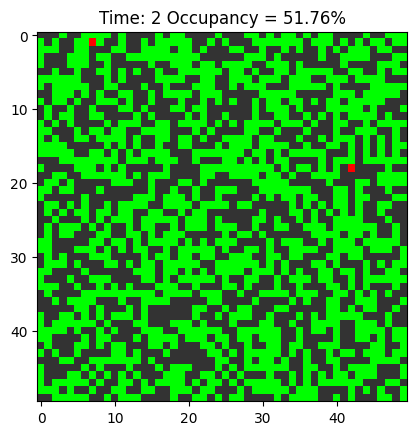

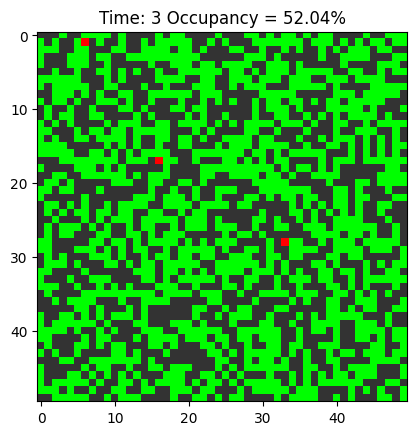

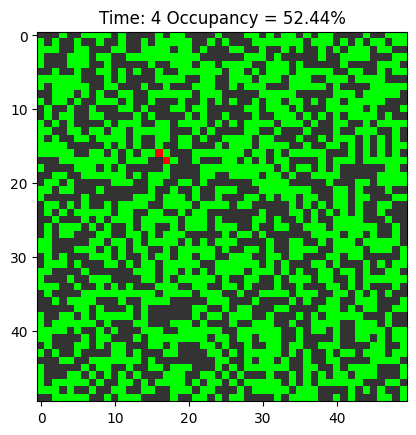

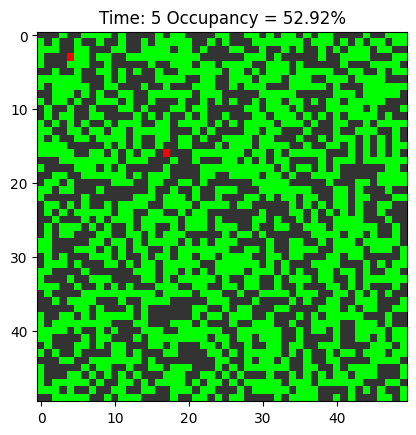

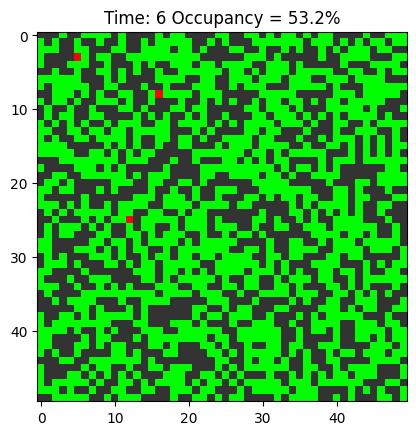

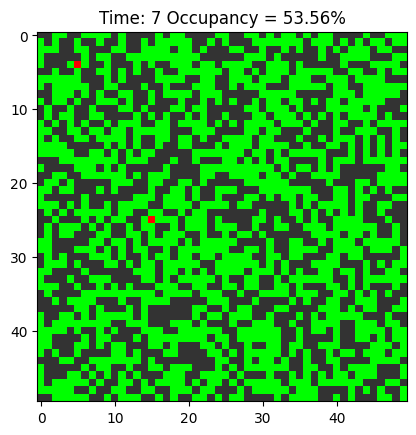

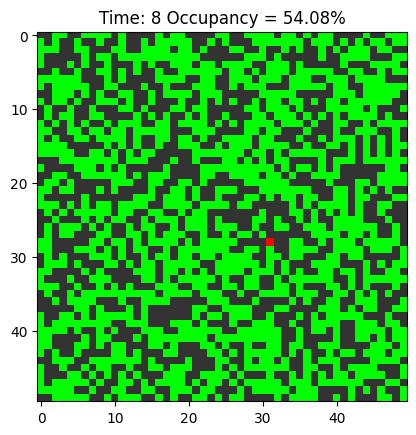

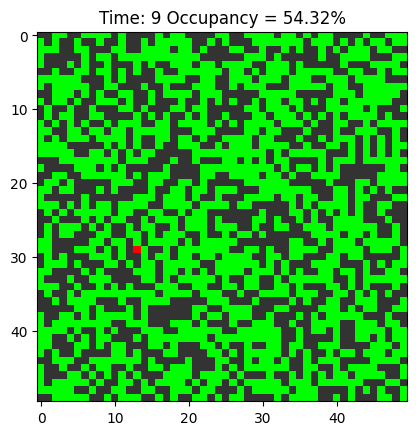

{'0': '50.92%',
 '1': '51.44%',
 '2': '51.76%',
 '3': '52.04%',
 '4': '52.44%',
 '5': '52.92%',
 '6': '53.2%',
 '7': '53.56%',
 '8': '54.08%',
 '9': '54.32%'}

In [452]:

import matplotlib.colors
import scipy.signal as sp_signal

class ForestFire:
    """2D Cellular Automaton that simulates a fire-dominated landscape"""

    EMPTY = 0
    OCCUPIED = 1
    FIRE = 5

    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (0.2, 0.2, 0.2)  # grey
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[FIRE] = (1, 0, 0)  # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    kernel = np.array([[0.1, 0.5, 0.1],
                       [0.5, 0, 0.5],
                       [0.1, 0.5, 0.1]])

    def __init__(self, n, p, f, q):
        self.p = p
        self.f = f
        self.q= q
        self.size = n ** 2

        self.array = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])

    def step(self):
        neighborsonfire = sp_signal.convolve2d(self.array, self.kernel, mode="same") > 4
        empty = self.array == self.EMPTY
        occupied = self.array == self.OCCUPIED
        fire = self.array == self.FIRE

        self.array[fire] = self.EMPTY
        self.array[occupied] = np.random.choice(
            [self.FIRE, self.OCCUPIED], size=np.count_nonzero(occupied), p=[self.f, 1 - self.f]
        )
        self.array[neighborsonfire & occupied] = self.FIRE
        self.array[empty] = np.random.choice(
            [self.OCCUPIED, self.EMPTY], size=np.count_nonzero(empty), p=[self.p, 1 - self.p]
        )

    def num_occupied(self):
        return np.count_nonzero(self.array == self.OCCUPIED)

    def pct_occupied(self):
        return self.num_occupied() / self.size

    def draw(self, axes=None, step=''):
        axes = axes or plt.axes()
        title = f'Time: {step} Occupancy = {round(self.pct_occupied() * 100, 2)}%'
        axes.set_title(title)
        axes.imshow(self.array, cmap=self.forest_colour_map)
        plt.show()



fire_model = ForestFire(n=50, p= 0.01, f= 0.001, q=0.5)
occupancies= {}
for step in range(10):
    fire_model.step()
    fire_model.draw(step=str(step))
    occupancies[str(step)] = str(round(fire_model.pct_occupied() * 100, 2)) +'%'


occupancies


## Ex. 7.2: Animation
Create a simple animation (using Animate2D class provided) so we can visualize and verify the system dynamics

In [448]:
from matplotlib.animation import FuncAnimation

class ForestFire:
    """2D Cellular Automaton that simulates a fire-dominated landscape"""

    EMPTY = 0
    OCCUPIED = 1
    FIRE = 5

    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (0.2, 0.2, 0.2)  # grey
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[FIRE] = (1, 0, 0)  # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    kernel = np.array([[0.5, 0.5, 0.5],
                       [0.5, 0, 0.5],
                       [0.5, 0.5, 0.5]])
    def __init__(self, n, p, f, q):
        self.p = p
        self.f = f
        self.q = q
        self.size = n ** 2

        self.array = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])

    def step(self):
        neighborsonfire = sp_signal.convolve2d(self.array, self.kernel, mode="same") > 4
        empty = self.array == self.EMPTY
        occupied = self.array == self.OCCUPIED
        fire = self.array == self.FIRE

        self.array[fire] = self.EMPTY
        self.array[occupied] = np.random.choice(
            [self.FIRE, self.OCCUPIED], size=np.count_nonzero(occupied), p=[self.f, 1 - self.f]
        )
        self.array[neighborsonfire & occupied] = self.FIRE
        self.array[empty] = np.random.choice(
            [self.OCCUPIED, self.EMPTY], size=np.count_nonzero(empty), p=[self.p, 1 - self.p]
        )

    def num_occupied(self):
        return np.count_nonzero(self.array == self.OCCUPIED)

    def pct_occupied(self):
        return self.num_occupied() / self.size

    def draw(self, axes=None, step=''):
        axes = axes or plt.axes()
        title = f'Time: {step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
        axes.set_title(title)
        axes.imshow(self.array, cmap=self.forest_colour_map)
        plt.show()

    def animate(self, steps=10, interval=500, save_path=None):
        fig, ax = plt.subplots()
        ax.set_title("Forest Fire Simulation")

        def update(frame):
            ax.clear()
            self.step()
            ax.imshow(self.array, cmap=self.forest_colour_map)
            ax.set_title(f"Time: {frame} Occupancy= {round(self.pct_occupied() * 100, 2)}%")

        animation = FuncAnimation(fig, update, frames=range(steps), interval=interval)

        if save_path:
            animation.save(save_path, writer="imagemagick", fps=1)
        else:
            plt.show()

        plt.close(fig)  # Close the figure after animation

class Animation2D:
    def __init__(self, model, frames):
        self.model = model
        self.frames = frames

    def animate(self, interval=500, save_path=None):
        plt.rcParams['animation.html'] = 'jshtml'  # Set animation rendering to JSHTML

        fig, ax = plt.subplots()
        ax.set_title("Forest Fire Animation")

        def update(frame):
            ax.clear()
            self.model.step()
            ax.imshow(self.model.array, cmap=self.model.forest_colour_map)
            ax.set_title(f"Time: {frame} Occupancy: {round(self.model.pct_occupied() * 100, 2)}%")

        animation = FuncAnimation(fig, update, frames=self.frames, interval=interval)
        plt.close(fig)  # Close the figure after animation

        return animation

forest = ForestFire(40, p= 0.01, f=0.001, q= 0.5)
for x in range(200):
    forest.step()
anim = Animation2D(forest, frames=50)
animation = anim.animate(interval= 100)
animation







### Question 7.3:
In what ways is this model similar to Diffusion and/or Percolation?
What kinds of behaviours might we predict from this more complex model based on what we learned from the simpler Diffusion and/or Precolation models?
Provide concise (brief, point-form) answers below:

#### Answers:


This model is similar to diffusion suc that we can see the spread of fire in the forest according the fire in neighbouring cells. We can predict the way fire is gonna spread based on the probability of existance of fire a point, area under fire depending on the total number of cells under fire. This is similar to diffusion as it also depends on the amount of, lets say ink in water.

It can be compared to persolation as it shows how the probability of one thing shows its dominance overall. like if the probability of fire without any neighbouing cells on fire is higher that 0.5, after some steps, most of the area will be under fire after some steps and will be barn land eventually.

# Lab 8:  Temporal Dynamics: Stability and Equilibrium

The [dynamics](https://en.wikipedia.org/wiki/System_dynamics) of a system describe how it changes over time.  In mathematics, we typically express dyanamics with differential equations (i.e., expressing change over time).  In computation, we typically use a simulation model, like the one developed in Lab 7.

Please watch: [Basic System Dyanmics (15 min)](https://youtu.be/qlRM1JlxfkU) for a quick introduction to these concepts.

---------------------
In this lab we will explore the patterns our `ForestFire` model traces out over time.  We'll try to determine if the model is stable or chaotic, whether there are any circumstances where it reaches [equilibirum](https://en.wikipedia.org/wiki/Mechanical_equilibrium)

## Ex. 8.1: Exploratory Analysis
Explore the behaviour of the model we defined above.
 1. Alter the model's initial conditions - how does the behaviour change depending on the initial proportion of forested vs. empty cells?
 2. Alter the regeneration and fire frequency parameters, $p$ and $f$, to see how this changes the model behaviour - how does the behaviour change as you increase or decrease each of these model parameters?

{'initially': 0.2, 0: 20.36, 1: 21.48, 2: 22.12, 3: 22.88, 4: 23.92, 5: 24.92, 6: 25.68, 7: 26.48, 8: 27.32, 9: 28.12, 10: 29.0, 11: 29.68, 12: 30.04, 13: 30.68, 14: 31.52, 15: 31.96, 16: 32.76, 17: 33.4, 18: 33.88, 19: 34.48}


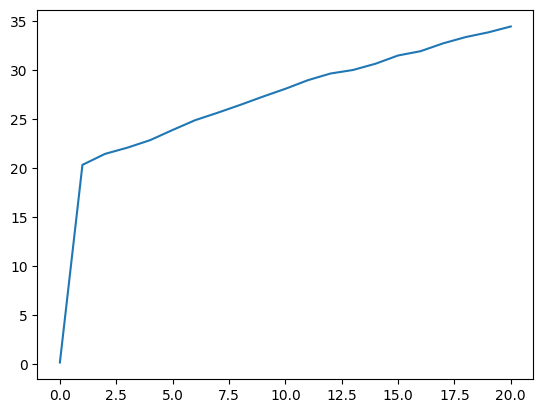

In [453]:

fire_model = ForestFire(n=50, p= 0.01, f= 0.001, q= 0.2)

occupancies= {'initially' : fire_model.q }
graph= []
for step in range(20):
    fire_model.step()
    #fire_model.draw(step=str(step))
    occupancies[step] = (round(fire_model.pct_occupied() * 100, 2))

graph= [ i for i in occupancies.values()]
plt.plot(graph, scaley= True)
print(occupancies)



Percenage occupancies corrosponding to the steps are {'initially': 0.0, 1: 1.2, 2: 2.12, 3: 3.76, 4: 4.44, 5: 5.48, 6: 6.88, 7: 7.68, 8: 8.56, 9: 9.32, 10: 9.92, 11: 10.96, 12: 11.72, 13: 12.76, 14: 13.6, 15: 14.36, 16: 15.08, 17: 16.16, 18: 16.84, 19: 17.68, 20: 18.48, 21: 19.24, 22: 19.76, 23: 20.28, 24: 20.96, 25: 21.64, 26: 22.44, 27: 23.24, 28: 23.96, 29: 24.92, 30: 25.52, 31: 26.2, 32: 27.0, 33: 27.76, 34: 28.48, 35: 29.2, 36: 29.76, 37: 30.44, 38: 31.28, 39: 32.12, 40: 32.8, 41: 33.36, 42: 34.12, 43: 34.64, 44: 35.2, 45: 36.16, 46: 36.96, 47: 37.6, 48: 38.0, 49: 38.52, 50: 39.36, 51: 39.8, 52: 40.36, 53: 41.12, 54: 41.6, 55: 42.2, 56: 42.76, 57: 43.32, 58: 43.68, 59: 43.92, 60: 44.6, 61: 45.16, 62: 45.8, 63: 46.0, 64: 46.4, 65: 46.6, 66: 47.12, 67: 47.48, 68: 47.92, 69: 48.36, 70: 48.84, 71: 49.16, 72: 49.96, 73: 50.4, 74: 50.76, 75: 51.24, 76: 51.64, 77: 52.0, 78: 52.36, 79: 52.6, 80: 53.16, 81: 53.6, 82: 54.2, 83: 54.36, 84: 54.8, 85: 55.44, 86: 55.76, 87: 55.96, 88: 56.08, 89

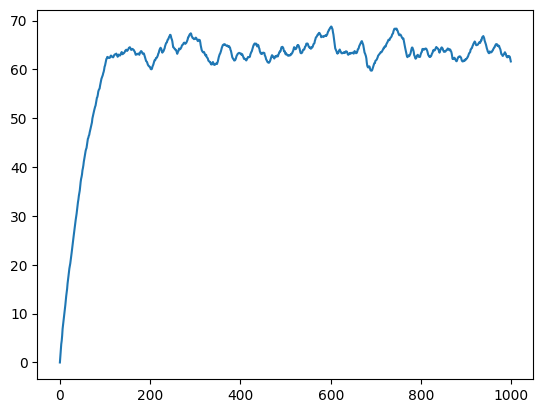

In [454]:
fire_model = ForestFire(n=50, p= 0.01, f= 0.001, q= 0.0)

occupancies= {'initially' : fire_model.q }
graph = []
for step in range(1,1000):
    fire_model.step()
    #fire_model.draw(step=str(step))
    occupancies[step] = round(fire_model.pct_occupied() * 100, 2)


print(f'Percenage occupancies corrosponding to the steps are {occupancies}')
graph= [ i for i in occupancies.values()]

plt.plot(graph, scaley= True)




#For a model with a forest, practically empty, the forest grows overall with time till it reaches about the value of 30%. For these values, it then fluctuates between 25 and 33 afterwards

Percenage occupancies corrosponding to the steps are {'initially': 100.0, 1: 99.88, 2: 99.36, 3: 98.16, 4: 96.0, 5: 92.52, 6: 87.6, 7: 81.44, 8: 74.36, 9: 66.68, 10: 59.2, 11: 52.16, 12: 45.36, 13: 38.84, 14: 32.44, 15: 26.32, 16: 21.28, 17: 18.44, 18: 16.72, 19: 16.08, 20: 16.04, 21: 16.48, 22: 16.64, 23: 17.24, 24: 18.08, 25: 18.84, 26: 19.4, 27: 20.08, 28: 20.72, 29: 21.56, 30: 22.24, 31: 22.44, 32: 23.24, 33: 23.84, 34: 24.8, 35: 25.52, 36: 26.16, 37: 26.84, 38: 27.56, 39: 28.24, 40: 28.72, 41: 29.4, 42: 29.84, 43: 30.6, 44: 31.2, 45: 31.68, 46: 32.36, 47: 33.08, 48: 33.68, 49: 34.4, 50: 35.4, 51: 36.08, 52: 36.68, 53: 37.44, 54: 37.96, 55: 38.44, 56: 39.04, 57: 39.2, 58: 39.72, 59: 40.48, 60: 41.0, 61: 41.64, 62: 42.08, 63: 42.56, 64: 43.08, 65: 43.6, 66: 44.44, 67: 45.08, 68: 45.48, 69: 45.92, 70: 46.44, 71: 47.08, 72: 47.68, 73: 48.0, 74: 48.32, 75: 48.72, 76: 49.56, 77: 49.84, 78: 50.12, 79: 50.44, 80: 51.0, 81: 51.24, 82: 51.64, 83: 51.96, 84: 52.28, 85: 52.76, 86: 53.48, 87: 

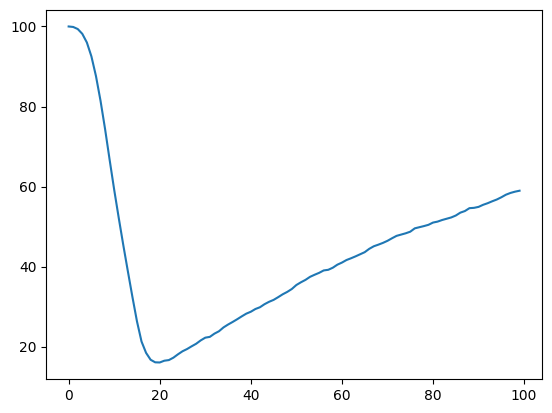

In [455]:
fire_model = ForestFire(n=50, p= 0.01, f= 0.001, q= 1.0)

occupancies= {'initially' : fire_model.q*100}
for step in range(1,100):
    fire_model.step()
    #fire_model.draw(step=str(step))
    occupancies[step] = round(fire_model.pct_occupied() * 100, 2)

print(f'Percenage occupancies corrosponding to the steps are {occupancies}')

graph= [ i for i in occupancies.values()]

plt.plot(graph, scaley= True)

# It can be understood that for the model with forest initially full with trees, all of that burns in first step, or first few steps, giving us the same model as that for empty land afterwards.

Percenage occupancies corrosponding to the steps are {'initially': 50.0, 1: 48.92, 2: 49.24, 3: 49.68, 4: 50.08, 5: 50.48, 6: 50.88, 7: 51.48, 8: 51.96, 9: 52.56, 10: 52.92, 11: 53.36, 12: 53.6, 13: 54.0, 14: 54.36, 15: 54.76, 16: 55.12, 17: 55.68, 18: 55.76, 19: 55.72, 20: 56.12, 21: 56.4, 22: 56.48, 23: 56.68, 24: 56.84, 25: 57.2, 26: 57.6, 27: 57.56, 28: 57.6, 29: 57.52, 30: 58.2, 31: 58.48, 32: 58.68, 33: 59.12, 34: 59.56, 35: 59.76, 36: 59.92, 37: 60.0, 38: 60.32, 39: 60.68, 40: 60.68, 41: 61.32, 42: 61.64, 43: 61.92, 44: 62.2, 45: 62.44, 46: 62.56, 47: 62.76, 48: 62.92, 49: 62.88, 50: 63.16, 51: 63.4, 52: 63.72, 53: 63.96, 54: 64.28, 55: 64.56, 56: 64.64, 57: 64.92, 58: 65.28, 59: 65.68, 60: 65.64, 61: 65.6, 62: 65.72, 63: 65.76, 64: 65.64, 65: 65.76, 66: 65.48, 67: 65.4, 68: 65.48, 69: 65.48, 70: 65.72, 71: 65.84, 72: 65.8, 73: 65.96, 74: 66.2, 75: 66.16, 76: 66.12, 77: 66.08, 78: 66.24, 79: 66.24, 80: 66.12, 81: 66.2, 82: 66.32, 83: 66.4, 84: 66.32, 85: 66.2, 86: 65.96, 87: 65.

<function matplotlib.pyplot.show(close=None, block=None)>

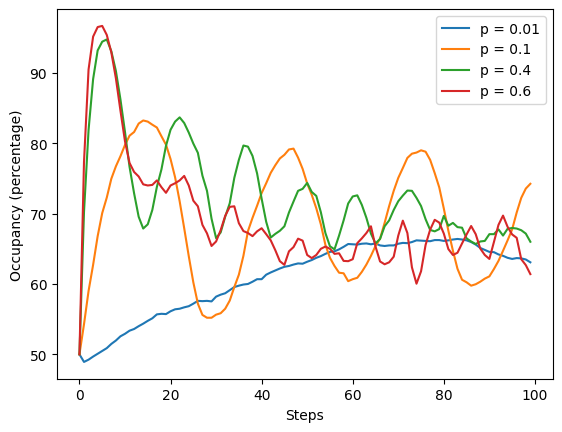

In [456]:
# To see how p impacts the model

fire_model = ForestFire(n=50, p= 0.01, f= 0.001, q= 0.5)

occupancies= {'initially' : fire_model.q*100}
for step in range(1,100):
    fire_model.step()
    #fire_model.draw(step=str(step))
    occupancies[step] = round(fire_model.pct_occupied() * 100, 2)
#print(f'Percenage occupancies corrosponding to the steps are {occupancies}')

graph1= [ i for i in occupancies.values()]

fire_model1 = ForestFire(n=50, p= 0.1, f= 0.001, q= 0.5)
occupancies1= {'initially' : fire_model1.q*100}
for step in range(1,100):
    fire_model1.step()
    #fire_model.draw(step=str(step))
    occupancies1[step] = round(fire_model1.pct_occupied() * 100, 2)
#print(f'Percenage occupancies corrosponding to the steps are {occupancies1}')

graph2= [ i for i in occupancies1.values()]


fire_model2 = ForestFire(n=50, p= 0.4, f= 0.001, q= 0.5)
occupancies2= {'initially' : fire_model2.q*100}
for step in range(1,100):
    fire_model2.step()
    #fire_model.draw(step=str(step))
    occupancies2[step] = round(fire_model2.pct_occupied() * 100, 2)
#print(f'Percenage occupancies corrosponding to the steps are {occupancies2}')

graph3= [ i for i in occupancies2.values()]


fire_model3 = ForestFire(n=50, p= 0.6, f= 0.001, q= 0.5)
occupancies3= {'initially' : fire_model3.q*100}
for step in range(1,100):
    fire_model3.step()
    #fire_model.draw(step=str(step))
    occupancies3[step] = round(fire_model3.pct_occupied() * 100, 2)
#print(f'Percenage occupancies corrosponding to the steps are {occupancies3}')

graph4= [ i for i in occupancies3.values()]




print(f'Percenage occupancies corrosponding to the steps are {occupancies}')


plt.plot(graph1, label= f'p = {fire_model.p}')
plt.plot(graph2,  label= f'p = {fire_model1.p}')
plt.plot(graph3, label= f'p = {fire_model2.p}')
plt.plot(graph4,  label= f'p = {fire_model3.p}')
plt.xlabel('Steps')
plt.ylabel('Occupancy (percentage)')
plt.legend()
plt.show

## Ex. 8.2: Steady State
Many complex systems never achieve a static [equilibirum](https://en.wikipedia.org/wiki/Mechanical_equilibrium), instead their state fluctuates around a value, called an ["attractor"](https://en.wikipedia.org/wiki/Attractor).  A system that is not trending is said to be in ["steady state"](https://en.wikipedia.org/wiki/Steady_state).
Starting from a random initial condition, run the model until it reaches a "steady state" where the number of occupied cells is no longer trending (consistently increasing or decreasing).

Design an experimental setup that allows you to detect when the system is in steady state with respect to the number of forested cells.
This need not be fancy and need not automate the detection of steady state, so long as it provides some output that allows you to detect how long it takes for the system to settle into an equilibrium or cyclical pattern.

In [457]:
# I already gave 2 ways above, making graphs and dictionaries, that can be useful here.

### Question 8.3:
Starting with a uniform random landscape, $q$ = 0.5, find the steady state proportion of forested cells of this system for 3 different combinations of $p$ and $f$, and the approx. number of time steps required to reach steady state.
Fill in the table below with your experimental results:

| p  | f   | steady-state | time steps | Cyclical? |
|----|-----|--------------|------------|-----------|
| 0.01 | 0.001 | no       | -         | n         |
| 0.1  | 0.001 | no           | 40         | y         |
| 0.6  | 0.001 | no           | 20         | y         |


## Ex. 8.4: Stability
A system is ["stable"](https://en.wikipedia.org/wiki/Ecological_stability) if it returns to its former steady state after a [disturbance](https://en.wikipedia.org/wiki/Disturbance_(ecology))

A disturbance in our case might be an extreme fire year or an insect outbreak that changes the forest's susceptibility to fire, or several years of reduced regeneration due to a soil fungus killing seedlings.
How could you emulate a disturbance like this in your model?  If you want to modify the model in some way, that's OK, but you may also find ways to emulate a disturbance as an "external forcing function".

Run your model to steady-state, then emulate a major disturbance (over one or more time steps) to "perturb" the system away from its steady state.  Remove the external force and measure how long it takes for the system to return to steady state.

{'initially': 55.00000000000001, 0: 53.68, 1: 54.0, 2: 54.36, 3: 54.72, 4: 54.88, 5: 55.4, 6: 55.88, 7: 56.4, 8: 56.64, 9: 57.12, 10: 57.44, 11: 57.88, 12: 58.24, 13: 58.64, 14: 58.84, 15: 59.48, 16: 59.68, 17: 59.8, 18: 60.4, 19: 60.96, 20: 61.36, 21: 61.72, 22: 62.04, 23: 62.24, 24: 62.32, 25: 62.16, 26: 62.12, 27: 62.64, 28: 62.76, 29: 63.12, 30: 63.32, 31: 63.6, 32: 63.92, 33: 64.12, 34: 64.48, 35: 64.52, 36: 64.56, 37: 64.84, 38: 64.96, 39: 64.92, 40: 65.2, 41: 65.08, 42: 65.08, 43: 64.84, 44: 65.0, 45: 64.64, 46: 64.76, 47: 64.64, 48: 64.56, 49: 64.4, 50: 64.48, 51: 64.44, 52: 64.32, 53: 64.52, 54: 64.84, 55: 65.0, 56: 65.04, 57: 65.24, 58: 65.28, 59: 65.0, 60: 65.24, 61: 65.56, 62: 65.52, 63: 65.44, 64: 65.36, 65: 64.96, 66: 64.72, 67: 64.68, 68: 64.32, 69: 64.08, 70: 64.28, 71: 64.6, 72: 64.72, 73: 64.92, 74: 65.12, 75: 65.36, 76: 65.6, 77: 66.08, 78: 66.12, 79: 66.32, 80: 24.28, 81: 12.84, 82: 17.32, 83: 20.08, 84: 19.32, 85: 18.2, 86: 19.72, 87: 18.32, 88: 19.04, 89: 17.44, 9

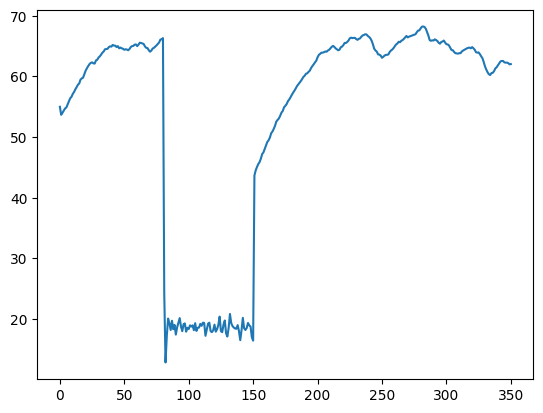

In [458]:
fire_model = ForestFire(n=50, p= 0.01, f= 0.001, q= 0.55)

occupancies= {'initially' : fire_model.q*100 }
graph= []
for step in range(80):
    fire_model.step()
    #fire_model.draw(step=str(step))
    occupancies[step] = (round(fire_model.pct_occupied() * 100, 2))

fire_model_1 = ForestFire(n=50, p= 0.2, f= 0.7, q= 0.4)       #lets say there were way too many spontaneous fires that year due to high temperatures
for step in range(80,150):
    fire_model_1.step()
    #fire_model.draw(step=str(step))
    occupancies[step] = (round(fire_model_1.pct_occupied() * 100, 2))

fire_model = ForestFire(n=50, p= 0.01, f= 0.001, q= 0.435)

for step in range(150,350):
    fire_model.step()
    #fire_model.draw(step=str(step))
    occupancies[step] = (round(fire_model.pct_occupied() * 100, 2))

graph= [ i for i in occupancies.values()]
plt.plot(graph)
print(occupancies)



### Question 8.4:
Does the model tend to return to the same steady-state, or does the attractor move to a different value?
How long does it take for the model to return to steady-state dynamics?
Does it appear to matter to these results how large the disturbance is?
What does that tell you about the number of "attractors" in this system?

#### Answers:


We can see that increasing the chances of spontaneous fire causes a dip in the graph that starts to recover as soon as the initail conditions are maintianes. It takes less than 100 steps to come back to its intial state.There are 2 attractors in the system, one for initial conditions and the other one for the temporary, with more fires, state.

# Lab 9: Patch Size Distribution

The spatial patterns that emerge from this model tends to be landscapes with patches of forested and un-forested land of varying size.  A question naturally arises about this pattern:
  * what is the size of patches created by fire?
    This will alos tell us something about forest [fragmentation](https://en.wikipedia.org/wiki/Habitat_fragmentation), which impacts wildlife habitat, for example.

Notice that rather than a single number, we will get a [distribution](https://en.wikipedia.org/wiki/Probability_distribution) of values for patch sizes.  The shape of this distribution emerges from the system dynamics, and serves as a way to compare our model results with empirical observations of patch-size distributions in real ecosystems.

In this lab we will explore the spatial patterns our `ForestFire` model makes.  We'll ask if these patterns have a [heavy-tail distribution](https://en.wikipedia.org/wiki/Heavy-tailed_distribution) and thus exhibit [self-organizing criticality](https://en.wikipedia.org/wiki/Self-organized_criticality)

### Identifying Contiguous Patches

This is a surprisingly challenging problem to solve in the general case given how good our visual system is at identifying them!
The idea I had here was to start by giving each forested cell a unique value, then "grow" patches by allowing the smallest of these unique values to propagate to neighbouring cells.  Repeat until the propagation is finished.  In the end, all the cells in each contiguous patch have the same, unique identifier.
Notice that this is a modified diffusion / percolation algorithm - they are actually useful!

In [459]:
neighbourhood = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0],
])


def min_neighbour(a):
    """ Return the smallest non-zero neighbourhood value or 0 if centre cell is a zero """
    p = a * neighbourhood
    centre = tuple(d // 2 for d in a.shape)
    return np.min(p[p > 0]) if a[centre] else 0


def consolidate(array):
    """ return copy of array with adjacent cells consolidated into a patch with the lowest value among occupied neighbours """
    rows, cols = array.shape
    k = neighbourhood.shape[0]
    array = np.pad(array, 1, 'constant')
    return np.array([
        [min_neighbour(array[row:row + k, col:col + k]) for col in range(cols)]
        for row in range(rows)
    ])


def patchify(array, patch_category):
    """ Return an array with each contiguous patch identified by a unique integer
    array:  array of int categorical values
    category: the category value to identify patches for

    return: array of same shape with a unique value identifying cells in each patch and zeros elsewhere
    """
    patches = np.zeros(array.shape, dtype=np.uint)
    # assign each cell that falls in a patch a unique number, 1 .. N
    patches[array == patch_category] = range(1, len(array[array == patch_category]) + 1)

    patches_growing = np.array([True, ])
    while np.any(patches_growing):
        prev_patches = patches
        patches = consolidate(prev_patches)
        patches_growing = patches != prev_patches  # patches are growning until consolidate algorithm stabilizes.

    return patches

## Ex. 9.1 Patch Size Distribution

Run your model to steady-state, and `patchify` the model state.
You might want to plot these beside each other to verify that `patchify` is working as expected.

With a unique value assigned to each patch, we can tally up the size of each patch simply by counting the number of cells for each unique value.
*Tip*: use [numpy.unique](https://numpy.org/doc/stable/reference/generated/numpy.unique.html), with `return_counts=True`, which does exactly the job we want.

Once you have an array of patch-size counts, create a histogram to display the distribution of patch sizes.
You could feed the raw patch-size count data to [pyplot.hist](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html), but you'll get a much nicer graph if you tally the number of patches in each size class yourself and use [pyplot.bar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html) to do the plotting.
*Tip*: `np.unique` will also tally up the number of patches in each size class from the patch-size array!

In [460]:
# Ex. 9.1 here

## Ex. 9.2 Heavy-tailed distribution?
The textbook author published a small Python package that encapsulates some of the work we did above to compute the "empirical distribution" from an array of data.  In paricular, his `PMF()` ([Probability Mass Function](https://en.wikipedia.org/wiki/Probability_mass_function)) function converts an array of unique values into an emirical distribution suitable for plotting

You can see how this function is used in Ch. 10.5.
And/Or check how it is used in the [chap10.ipynb notebook](https://github.com/pearcej/complex-colab/blob/master/notebooks/chap10.ipynb) in the complex-colab repo.
And/Or look at the [API Documentation](https://nbviewer.org/github/AllenDowney/empiricaldist/blob/master/empiricaldist/dist_demo.ipynb)

In [461]:
# from empiricaldist import Pmf

Create a plot of the patch size distribution, both on a linear and log-log scale, similar to the example in Ch. 10.5

In [462]:
# Ex. 9.2 here

### Question 9.3

Does the patch size distribution appear to follow the power law?
Does it show any signs of being a "heavy-tailed" distribution?
If it does, what might the implications be for our understanding of the dynamics of real forest ecosystems?

#### Answers


---------------------

# Lab 10:  Fractal Dimension

I highly recommend you start with this [**_2Blue1Brown Video_**](https://youtu.be/gB9n2gHsHN4), if you've not yet seen it.

-----------------
In this lab we will calculate the [fractal dimension](https://en.wikipedia.org/wiki/Fractal_dimension) of the forested areas thatour `ForestFire` model generates.

## Ex. 10.1 Box Counting

We'll use the [box counting](https://en.wikipedia.org/wiki/Box_counting) algorithm, which, in essence, estimates how the measured amount of forested area scales at different sized counting grids (2D rulers).  You are welcome to pilfer the `box_count` code developed for measuring fractal dimension in the **Precolation** model.

Run your model forward to steady-state, and use the box counting algorithm to estimate how the pattern of forested patches scales.  The result here show how the count of "forested" cells scales with the size of the "box" (grid cell) used to do the counting.
Just looking at the results, do you think this is closer to a linear or a squared scaling factor?

In [463]:
# Ex. 10.1 here

## Ex. 10.2  Estimate Fractal Dimension

If we plot the count of forested cells versus the size of the "box" on a log-log scale, the slope estimates the fractal dimension.

Estimate the slope of your box-count data using a log-log linear regression (again, feel free to pilfer the `log_slope` function).
Plot the graph that shows the box-count data in relation to a simple linear and square scaling relation (again, pilfer code as needed).

In [464]:
# Ex. 10.2 here

## Ex. 10.3  Scaling Experiment

In our study of Percolation patterns, we plotted the scaling factor and fractal dimension to visualize how the pattern scales compared to simple linear and square scaling.  We set up an experiment to explore how fractal dimension changed for different model paraemter values, and to idenify a critical values where [phase transitions](https://en.wikipedia.org/wiki/Phase_transition) occur.

Repeat these experiments for the `ForestFire` model.  Again, you may adapt the code developed for Percolation.

In [465]:
# Ex. 10.3 here

### Question 10.4:
How does the fractal dimension change for different values of $p$ and $f$?
Does there appear to be a critical value where the fractal dimension goes through a phase change, like we saw for Percolation?
What conclusions might your draw about the complexity of forest edges in real forest ecosystems?  How does this compare the the man-made edges that typically result from industrial logging?

#### Answers: